Download the data into it's own folder (**data**) and read it in from there so we don't need a network connection to get at it later.  Set <code>stringsAsFactors = FALSE</code> because we'll do this manually ourselves.

In [1]:
# get the training data here: https://www.kaggle.com/c/titanic/data/train.csv
#data_all <- read.csv("../data/titanic_train.csv", na.strings = c("NA", ""), stringsAsFactors = FALSE)
data_all <- read.csv("https://raw.githubusercontent.com/MichaelSzczepaniak/WonderfulML/master/data/titanic_train.csv", na.strings = c("NA", ""), stringsAsFactors = FALSE)
head(data_all)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


Looks like there is some missing data that we'll need to deal with.  Let's start by determining the numer of missing values in each field.

In [2]:
na_count <- sapply(data_all, function(y) sum(length(which(is.na(y)))))
na_count <- data.frame(na_count)
na_count

,na_count
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Let's take a quick look at **Survival** by **Sex** and **Pclass**.

In [3]:
data_all$Survived <- factor(data_all$Survived)
data_all$Sex <- factor(data_all$Sex)
sort(unique(data_all$Pclass))

[1] 1 2 3

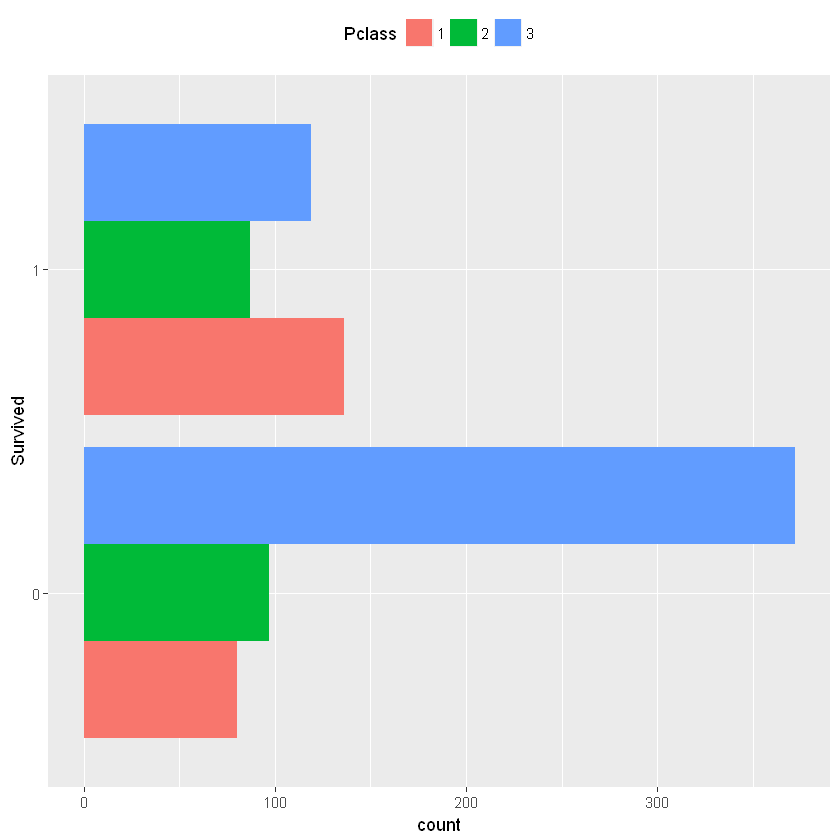

In [8]:
# magic commands are an ipython kernel thing and don't work in an R notebook...
#%%R -i df -w 800 -h 480 -u px
library(ggplot2)
data_all$Pclass <- factor(data_all$Pclass)
p <- ggplot(data_all, aes(Survived))
options(jupyter.plot_mimetypes = 'image/png')
p <- p + geom_bar(aes(fill = Pclass), position = "dodge") + coord_flip()
p <- p + theme(legend.position = "top")
#p <- p + ggtitle(sprintf("Mime type = '%s'", getOption("jupyter.plot_mimetypes")))
print(p)



Looks like passengers who were in 1st class had a better chance of survival than 2nd or 3rd.